In [ ]:
import os
import sys
import numpy as np
import warnings
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

root_path = root_path = os.path.realpath('../..')
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from causaltune import CausalTune
from causaltune.datasets import iv_dgp_econml


warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

## Data Generation Process

Here we use a data generation process implemented by EconML for IV models and described as follows:

We construct the DGP as below. The instrument corresponds to a fully randomized recommendation of treatment. Then each sample complies with the recommendation to some degree. This probability depends on both the observed feature $X$ and an unobserved confounder that has a direct effect on the outcome


\begin{align}
W \sim \; & \text{Normal}(0,\, I_{n_w})   \tag{Observed confounders}\\
Z \sim \; & \text{Bernoulli}(p=0.5)   \tag{Instrument}\\
\nu \sim \; & \text{U}[0, 5] \tag{Unobserved confounder}\\
C \sim \; & \text{Bernoulli}(p=0.8 \cdot \text{Sigmoid}(0.4 \cdot X[0] + \nu))   \tag{Compliers when recommended}\\
C0 \sim \; & \text{Bernoulli}(p=0.006)   \tag{Non-Compliers when not recommended}\\
\theta = & \; 7.5\cdot X[2]\cdot X[8] \\
T = \; & C \cdot Z + C0 \cdot (1-Z)  \tag{Treatment}\\
y \sim \; & \theta \cdot T + 2 \cdot \nu + 5 \cdot (X[3]>0) + 0.1 \cdot \text{U}[0, 1]  \tag{Outcome}
\end{align}


### Model Fitting (1): Constant Effect (ATE)

We define a constant treatment effect (ATE) to be searched by CausalTune for all named IV estimators.

\begin{align}
\theta = \; & 7.5 \tag{ATE}\\
\end{align}

In [2]:
TRUE_EFFECT = 7.5

CONSTANT_EFFECT = lambda X: TRUE_EFFECT

cd = iv_dgp_econml(
    n=50000, 
    p=15, 
    true_effect=CONSTANT_EFFECT
    )

cd.preprocess_dataset()

outcome = cd.outcomes[0]

For each treatment effect example, we fit a list of 6 IV models, scoring them with an energy distance score. The dataset is split into train, validation and a hold-out test set, and we report scores for each.

As a baseline we use dowhy's simple IV estimator, implementing Wald's estimator and two-stage least squares (2SLS)
The other estimators are implemented by EconML with details [here](https://econml.azurewebsites.net/reference.html#instrumental-variable-cate-estimators)

The components time budget represent tuning budget allocated to each estimator model.

In [3]:
estimator_list = [
    'SparseLinearDRIV',
    "DMLIV", 
    "OrthoIV", 
    "LinearDRIV", 
    "LinearIntentToTreatDRIV"
    ]

ct_constant_te = CausalTune(
    estimator_list=estimator_list,
    components_time_budget=60,
    propensity_model="dummy",
    metrics_to_report=['ate']
)

ct_constant_te.fit(data=cd, outcome=outcome)


Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


 We get the estimated effect for the best estimator by energy distance score

In [5]:
def get_est_effects(models, test_x, te=TRUE_EFFECT):
    est_scores = []
    for est_name, scr in models.scores.items():
        est_effect = scr["estimator"].estimator.effect(test_x).mean()
        est_scores.append([est_name, est_effect, (est_effect-te)**2])

    return pd.DataFrame(est_scores, columns=["estimator", "estimated_effect", "ate_mse"])


In [6]:
for est, scr in ct_constant_te.scores.items():
    print(scr['scores'])

{'train': {'ate': 3.7364384981029586, 'ate_std': 0.20510902977134612, 'energy_distance': 0.7029531282263708}, 'validation': {'ate': 3.734421976771562, 'ate_std': 0.2049251316941464, 'energy_distance': 0.6222427775144297}}
{'train': {'ate': 7.626779393748574, 'ate_std': 0.20125071177945722, 'energy_distance': 0.000772274077755597}, 'validation': {'ate': 7.629709229352894, 'ate_std': 0.20032625271213847, 'energy_distance': 0.005352740458161698}}
{'train': {'ate': 3.7208785493387673, 'ate_std': 0.10722104154938497, 'energy_distance': 0.7118688533060924}, 'validation': {'ate': 3.7217320690014537, 'ate_std': 0.10729987588098862, 'energy_distance': 0.6285380917180117}}
{'train': {'ate': 5.677720797653403, 'ate_std': 0.10908975329250435, 'energy_distance': 0.17693554171975556}, 'validation': {'ate': 5.678236628824208, 'ate_std': 0.10866530296301631, 'energy_distance': 0.1417818193097089}}


First we see the estimated effect for each model, and respective MSE compared with true effect

In [8]:
get_est_effects(ct_constant_te, ct_constant_te.test_df)

,estimator,estimated_effect,ate_mse
0,iv.econml.iv.dml.DMLIV,3.734422,14.179578
1,iv.econml.iv.dml.OrthoIV,7.629709,0.016824
2,iv.econml.iv.dr.LinearDRIV,3.721732,14.275309
3,iv.econml.iv.dr.SparseLinearDRIV,5.678237,3.318822


In the plots we show the energy distance scores on the train, validation and hold-out test sets compared with the mean squared error between estimated effect and the true effect

In [18]:
cd_holdout_constant_te = iv_dgp_econml(
    n=10000, 
    p=15, 
    true_effect=CONSTANT_EFFECT
    )

cd_holdout_constant_te.preprocess_dataset()
ct_constant_te.score_dataset(df=cd_holdout_constant_te.data, dataset_name='test')

In [19]:
from causaltune.visualizer import Visualizer

viz = Visualizer(
    test_df=cd_holdout_constant_te.data,
    treatment_col_name=cd_holdout_constant_te.treatment,
    outcome_col_name=cd_holdout_constant_te.outcomes[0]
)

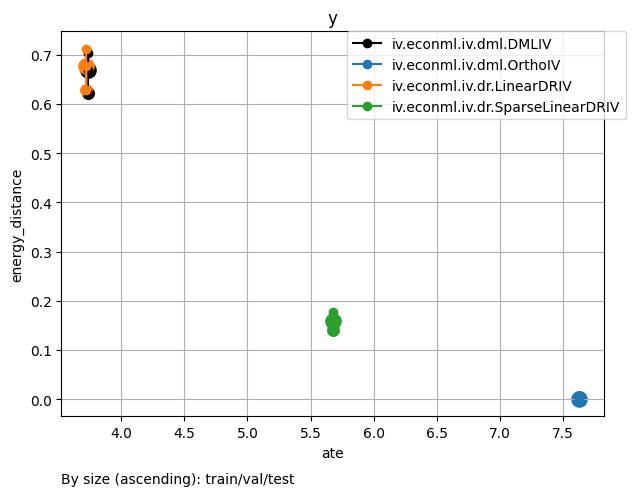

In [20]:
%matplotlib inline

# plotting metrics by estimator

figtitle = f'{viz.outcome_col_name}'
figsize = (7,5)
metrics = ('energy_distance', 'ate')

viz.plot_metrics_by_estimator(
    scores_dict=ct_constant_te.scores,
    metrics=metrics,
    figtitle=figtitle,
    figsize=figsize
)

### Model Fitting (2): Heterogeneous Treatment Effect

Here we replace the constant treatment effect with a linear treatment effect function of some covariates  to estimate heterogeneous effects.

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}

In [10]:
LINEAR_EFFECT = lambda X: TRUE_EFFECT * (X[:, 2] + X[:, 7])

cd = iv_dgp_econml(n=5000, p=15, true_effect=LINEAR_EFFECT)
cd.preprocess_dataset()

outcome = cd.outcomes[0]

In [11]:
ct_linear_te = CausalTune(
    estimator_list=estimator_list,
    components_time_budget=60,
    propensity_model="dummy",
)

ct_linear_te.fit(data=cd, outcome=outcome)

Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


In [12]:
get_est_effects(ct_linear_te, ct_linear_te.test_df)

,estimator,estimated_effect,ate_mse
0,iv.econml.iv.dml.DMLIV,0.156445,53.927795
1,iv.econml.iv.dml.OrthoIV,0.369256,50.847508
2,iv.econml.iv.dr.LinearDRIV,0.133582,54.264111
3,iv.econml.iv.dr.LinearIntentToTreatDRIV,0.297831,51.871241
4,iv.econml.iv.dr.SparseLinearDRIV,0.228978,52.867754


In [27]:
cd_holdout_linear_te = iv_dgp_econml(
    n=30000, 
    p=15, 
    true_effect=LINEAR_EFFECT
    )

cd_holdout_linear_te.preprocess_dataset()
ct_linear_te.score_dataset(df=cd_holdout_linear_te.data, dataset_name='test')

viz = Visualizer(
    test_df=cd_holdout_linear_te.data,
    treatment_col_name=cd_holdout_linear_te.treatment,
    outcome_col_name=cd_holdout_linear_te.outcomes[0]
)

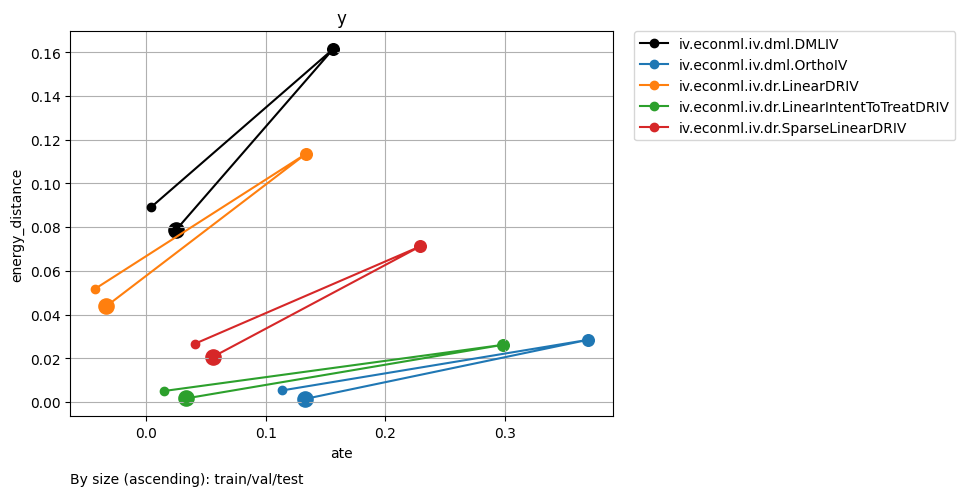

In [28]:
%matplotlib inline

# plotting metrics by estimator

figtitle = f'{viz.outcome_col_name}'
figsize = (7,5)
metrics = ('energy_distance', 'ate')

viz.plot_metrics_by_estimator(
    scores_dict=ct_linear_te.scores,
    metrics=metrics,
    figtitle=figtitle,
    figsize=figsize
)

### Model Fitting (3): Non-linear Heterogeneous Treatment Effect

Finally we explore non-linear heterogeneous treatment effects with the function below:

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}


In [14]:
QUADRATIC_EFFECT = lambda X: TRUE_EFFECT * (X[:, 2] ** 2)

cd = iv_dgp_econml(n=5000, p=15, true_effect=QUADRATIC_EFFECT)
cd.preprocess_dataset()

outcome = cd.outcomes[0]
cd.data.head()

,y,treatment,Z,random,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15
0,5.986360,0,0,1.0,-2.068259,-0.551331,-0.685723,0.581819,-0.596571,0.710344,1.678411,2.193095,1.149925,-0.550137,-1.470626,0.413178,-0.110334,-1.260494,1.381963
1,9.398978,0,0,0.0,0.646415,1.240161,-0.657972,0.467932,0.457930,0.398365,-0.722169,-0.869105,2.369392,0.091532,-0.237158,1.215416,0.608838,0.100998,1.602449
2,5.008451,1,1,1.0,-1.301893,-0.436542,-0.439291,-1.188172,0.952952,-1.209344,0.007173,-0.827154,1.420485,-0.469543,-1.534654,0.835242,-0.755796,0.176643,0.546620
3,31.748148,1,1,1.0,-0.403302,-0.580465,-1.711617,-0.051988,-0.676281,-0.872891,0.920118,-0.210665,-1.320596,-0.577391,0.362346,0.707947,0.476731,0.146383,2.478207
4,1.705930,1,1,0.0,-2.670358,2.039248,0.214640,-0.408820,0.844856,-2.127624,0.856064,-0.743294,0.206623,1.786020,-0.230643,-0.524102,1.332545,0.754762,0.065662


In [15]:
ct_quad_te = CausalTune(
    estimator_list=estimator_list,
    components_time_budget=60,
    propensity_model="dummy",
)

ct_quad_te.fit(data=cd, outcome=outcome)


Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


In [16]:
get_est_effects(ct_quad_te, ct_quad_te.test_df)

,estimator,estimated_effect,ate_mse
0,iv.econml.iv.dml.DMLIV,4.155144,1.118806e+01
1,iv.econml.iv.dml.OrthoIV,7.660507,2.576247e-02
2,iv.econml.iv.dr.LinearDRIV,3.755287,1.402288e+01
3,iv.econml.iv.dr.LinearIntentToTreatDRIV,7.499299,4.920311e-07
4,iv.econml.iv.dr.SparseLinearDRIV,5.038374,6.059600e+00


In [25]:
cd_holdout_quad_te = iv_dgp_econml(
    n=20000, 
    p=15, 
    true_effect=QUADRATIC_EFFECT
    )

cd_holdout_quad_te.preprocess_dataset()
ct_quad_te.score_dataset(df=cd_holdout_quad_te.data, dataset_name='test')

viz = Visualizer(
    test_df=cd_holdout_quad_te.data,
    treatment_col_name=cd_holdout_quad_te.treatment,
    outcome_col_name=cd_holdout_quad_te.outcomes[0]
)

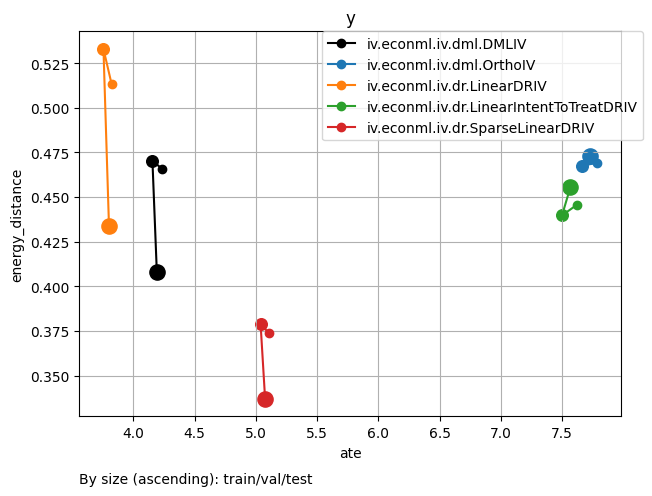

In [26]:
%matplotlib inline

# plotting metrics by estimator

figtitle = f'{viz.outcome_col_name}'
figsize = (7,5)
metrics = ('energy_distance', 'ate')

viz.plot_metrics_by_estimator(
    scores_dict=ct_quad_te.scores,
    metrics=metrics,
    figtitle=figtitle,
    figsize=figsize
)